# Análisis de la Telemetría de Mónaco
Este notebook realiza un análisis de clustering sobre datos de setups recolectados el circuito de **Mónaco**.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 📍 Paso 1: Preparación de los Datos - Circuito de Mónaco

En este paso cargamos el dataset sanetizado del circuito de Mónaco, eliminamos columnas irrelevantes (como `lapNumber` o identificadores), gestionamos valores nulos, y normalizamos los datos para su posterior análisis con técnicas de clustering.

Pasos específicos:
1. Cargar el dataset.
2. Eliminar columnas no necesarias para el clustering.
3. Filtrar vueltas inválidas (si `lapTime == 0`).
4. Normalizar las variables técnicas (`StandardScaler`).


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Cargar datos del circuito de Mónaco
df_monaco = pd.read_csv("/content/drive/MyDrive/Telemetria-F1-24/monaco_sanitized.csv")

# Vista previa de las primeras columnas
print("Columnas iniciales:", df_monaco.columns.tolist())
df_monaco.head()

Columnas iniciales: ['lapTimeInMS', 'm_frontWing', 'm_rearWing', 'm_onThrottle', 'm_offThrottle', 'm_frontCamber', 'm_rearCamber', 'm_frontToe', 'm_rearToe', 'm_frontSuspension', 'm_rearSuspension', 'm_frontAntiRollBar', 'm_rearAntiRollBar', 'm_frontSuspensionHeight', 'm_rearSuspensionHeight', 'm_brakePressure', 'm_brakeBias', 'm_engineBraking', 'm_rearLeftTyrePressure', 'm_rearRightTyrePressure', 'm_frontLeftTyrePressure', 'm_frontRightTyrePressure', 'm_ballast', 'm_fuelLoad', 'circuit']


,lapTimeInMS,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,...,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure,m_ballast,m_fuelLoad,circuit
0,70946,50,50,15,50,-3.4,-2.2,0.1,0.25,25,...,97,57,40,20.5,20.5,22.700001,22.700001,6,10.0,monaco
1,70544,50,50,60,30,-3.5,-2.2,0.0,0.20,38,...,100,54,100,26.5,26.5,29.500000,29.500000,6,10.0,monaco
2,71897,50,50,60,30,-3.5,-2.2,0.0,0.20,38,...,100,54,100,26.5,26.5,29.500000,29.500000,6,10.0,monaco
3,70246,50,50,60,30,-3.5,-2.2,0.0,0.20,38,...,100,54,100,26.5,26.5,29.500000,29.500000,6,10.0,monaco
4,70317,50,50,60,30,-3.5,-2.2,0.0,0.20,38,...,100,54,100,26.5,26.5,29.500000,29.500000,6,10.0,monaco


In [3]:
# Filtrar filas con tiempo de vuelta válido
df_monaco = df_monaco[df_monaco["lapTimeInMS"] > 0]

# Eliminar columnas irrelevantes
columns_to_drop = ['lapNumber', 'circuit', 'm_ballast', 'm_fuelLoad']
df_monaco = df_monaco.drop(columns=columns_to_drop, errors='ignore')

# Eliminar columnas completamente vacías
df_monaco = df_monaco.dropna(axis=1, how='all')

# Eliminar filas con valores nulos
df_monaco = df_monaco.dropna()

# Eliminar vueltas duplicadas (setup + tiempo idéntico)
df_monaco = df_monaco.drop_duplicates()

# Separar tiempos por vuelta y entradas
lap_times = df_monaco["lapTimeInMS"]
X_raw = df_monaco.drop(columns=["lapTimeInMS"])

print(f"Dataset limpio. Dimensiones finales: {X_raw.shape}")
X_raw.head()

Dataset limpio. Dimensiones finales: (91, 21)


,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,m_rearSuspension,...,m_rearAntiRollBar,m_frontSuspensionHeight,m_rearSuspensionHeight,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure
0,50,50,15,50,-3.4,-2.2,0.1,0.25,25,24,...,11,32,83,97,57,40,20.5,20.5,22.700001,22.700001
1,50,50,60,30,-3.5,-2.2,0.0,0.20,38,5,...,15,25,50,100,54,100,26.5,26.5,29.500000,29.500000
2,50,50,60,30,-3.5,-2.2,0.0,0.20,38,5,...,15,25,50,100,54,100,26.5,26.5,29.500000,29.500000
3,50,50,60,30,-3.5,-2.2,0.0,0.20,38,5,...,15,25,50,100,54,100,26.5,26.5,29.500000,29.500000
4,50,50,60,30,-3.5,-2.2,0.0,0.20,38,5,...,15,25,50,100,54,100,26.5,26.5,29.500000,29.500000


In [4]:
from sklearn.preprocessing import StandardScaler

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

print(f"Dataset limpio y normalizado. Dimensiones finales: {X_scaled.shape}")
X_scaled[:5]

Dataset limpio y normalizado. Dimensiones finales: (91, 21)


array([[ 0.        ,  0.47348022, -1.1228879 ,  1.04739983,  0.6798686 ,
        -0.28867513,  0.39877101,  1.17655133, -1.60085751,  1.73053715,
        -0.17701715, -0.15415454,  1.57449048,  1.89059764, -0.62944873,
         1.71567012, -0.60039742, -1.24779255, -1.24779255, -0.94559636,
        -0.94559636],
       [ 0.        ,  0.47348022,  0.38472716, -0.41895993, -0.50990183,
        -0.28867513, -0.7317013 ,  0.70406164,  0.49638992, -0.80299268,
         1.41395181,  0.73651612, -0.13120754, -1.00606803,  0.66257761,
         0.2565488 ,  1.11592191,  1.17674386,  1.17674386,  1.32942347,
         1.32942347],
       [ 0.        ,  0.47348022,  0.38472716, -0.41895993, -0.50990183,
        -0.28867513, -0.7317013 ,  0.70406164,  0.49638992, -0.80299268,
         1.41395181,  0.73651612, -0.13120754, -1.00606803,  0.66257761,
         0.2565488 ,  1.11592191,  1.17674386,  1.17674386,  1.32942347,
         1.32942347],
       [ 0.        ,  0.47348022,  0.38472716, -0.41895993

## ✳️ Paso 2: Reducción de Dimensionalidad

Para visualizar la distribución de los setups en el espacio latente, aplicaremos:

1. **PCA (Análisis de Componentes Principales)** para una reducción lineal.
2. **t-SNE (t-Distributed Stochastic Neighbor Embedding)** para una reducción no lineal, ideal para detectar estructuras complejas.

Ambos métodos nos ayudarán a inspeccionar visualmente si existe alguna agrupación natural entre los setups.

## Visualización con PCA

Cálculo de la varianza por componente. Seleccionamos aquel número de componentes que supere el umbral del 80% ya que nos indica que no supondrá una gran pérdida de información.

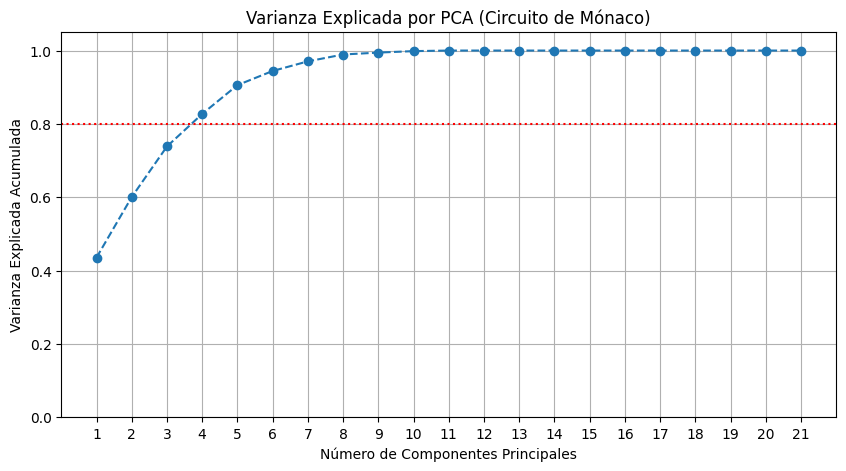

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Ajustar PCA conservando todos los componentes
pca_full = PCA()
pca_full.fit(X_scaled)

# Varianza explicada por componente
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Gráfico de varianza explicada
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var) + 1), cumulative_var, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por PCA (Circuito de Mónaco)')
plt.grid(True)
plt.xticks(range(1, len(explained_var) + 1))
plt.ylim(0, 1.05)
plt.axhline(y=0.8, color='r', linestyle=':')  # umbral típico del 80%
plt.show()

Gráfico con los  componentes.

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Aplicar PCA con 4 componentes
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

In [7]:
# Visualización PCA
import plotly.express as px
df_plotly = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4"])
fig = px.scatter_3d(df_plotly, x="PC1", y="PC2", z="PC3",
                    color="PC4", color_continuous_scale="Viridis",
                    title="PCA 3D (Color por PC4) - Circuito de Mónaco")
fig.show()

In [8]:
# Visualización con 3 dimensiones con tiempo por vuelta como color
df_plotly = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4"])
df_plotly["lapTime"] = lap_times.values
fig = px.scatter_3d(df_plotly, x="PC1", y="PC2", z="PC3",
                    color="lapTime", color_continuous_scale="Viridis",
                    title="PCA 3D (Color por lapTime) - Circuito de Mónaco",
                    labels={"lapTime": "lapTime (ms)"})
fig.show()

Visualizamos todas las combinaciones posibles entre 4 componentes (PC1 vs PC2, PC1 vs PC3, etc.).

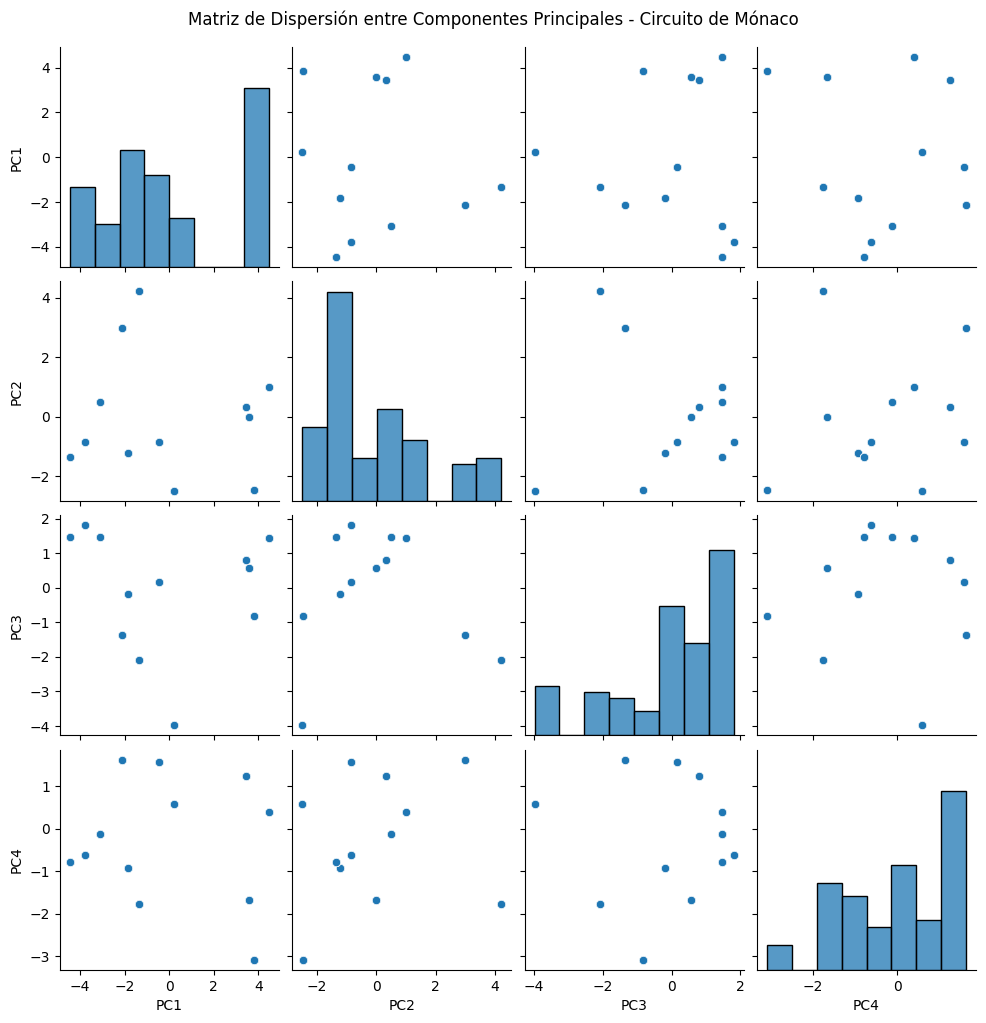

In [9]:
import pandas as pd
import seaborn as sns

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4"])
sns.pairplot(df_pca)
plt.suptitle("Matriz de Dispersión entre Componentes Principales - Circuito de Mónaco", y=1.02)
plt.show()

Gráfico de barras con la contribución de cada variable para cada uno de los dos componentes.

,PC1,PC2,PC3,PC4
m_rearSuspensionHeight,0.319733,0.020257,0.109467,-0.053559
m_rearSuspension,0.281438,0.033017,0.249039,0.144878
m_frontSuspensionHeight,0.271269,0.110989,0.301747,-0.026833
m_frontCamber,0.221420,0.049134,0.155813,-0.155562
m_brakeBias,0.158300,0.115650,0.297728,-0.343283
m_rearToe,0.122903,0.455879,0.084397,0.218754
m_offThrottle,0.119727,0.178887,0.124169,0.369256
m_rearCamber,0.118604,-0.001410,0.060125,-0.271717
m_frontToe,0.067185,0.494251,-0.141084,-0.045991
m_frontWing,-0.000000,0.000000,0.000000,-0.000000


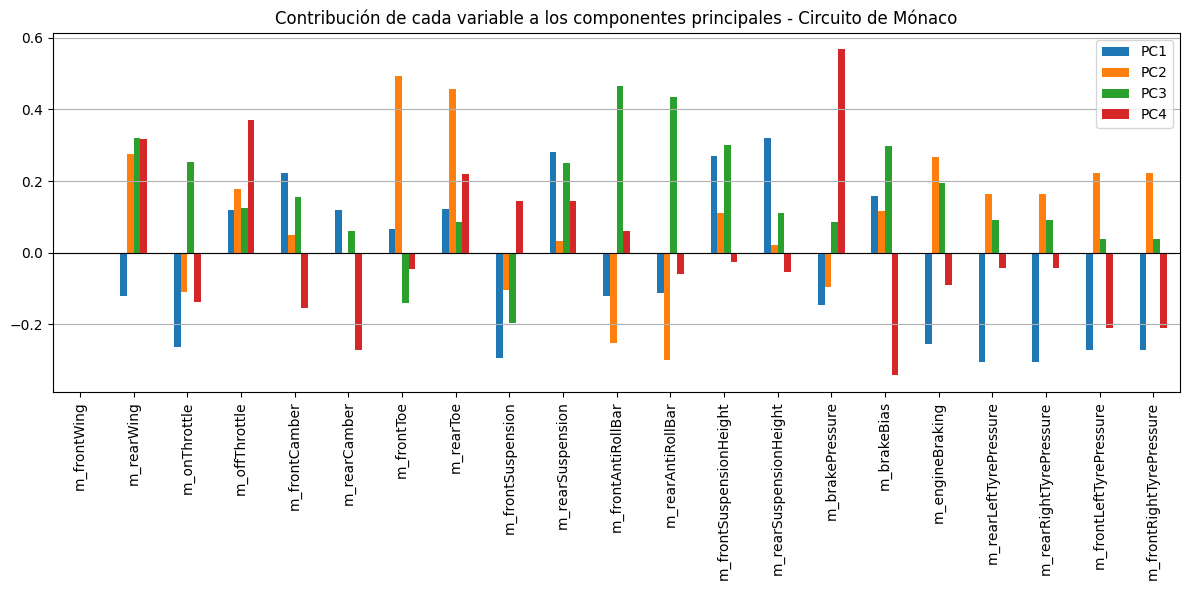

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los nombres de las variables originales
feature_names = X_raw.columns

# Obtener los loadings (coeficientes de cada variable en cada componente)
loadings = pd.DataFrame(pca.components_.T, index=feature_names,
                        columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Mostrar en tabla ordenada por importancia en PC1
display(loadings.sort_values(by='PC1', ascending=False))

# Visualización en gráfico de barras
loadings.plot(kind='bar', figsize=(12, 6))
plt.title("Contribución de cada variable a los componentes principales - Circuito de Mónaco")
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Top 5 contribuciones positivas/negativas por cada uno de los dos componentes.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Función para mostrar top 5 positivos y negativos de cada componente
def show_top_contributors(loadings, n=5):
    for pc in loadings.columns:
        print(f"\nTop {n} contribuciones positivas en {pc}:")
        print(loadings[pc].sort_values(ascending=False).head(n))

        print(f"\nTop {n} contribuciones negativas en {pc}:")
        print(loadings[pc].sort_values(ascending=True).head(n))

        # Visualización en gráfico de barras
        top_pos = loadings[pc].sort_values(ascending=False).head(n)
        top_neg = loadings[pc].sort_values().head(n)
        top_combined = pd.concat([top_pos, top_neg])

        plt.figure(figsize=(10, 5))
        top_combined.plot(kind='bar',
                          color=['green' if v > 0 else 'red' for v in top_combined])
        plt.title(f'Top {n} contribuciones en {pc} - Circuito de Mónaco')
        plt.axhline(0, color='black', linewidth=0.8)
        plt.ylabel("Peso en el componente")
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()


Top 5 contribuciones positivas en PC1:
m_rearSuspensionHeight     0.319733
m_rearSuspension           0.281438
m_frontSuspensionHeight    0.271269
m_frontCamber              0.221420
m_brakeBias                0.158300
Name: PC1, dtype: float64

Top 5 contribuciones negativas en PC1:
m_rearRightTyrePressure    -0.307238
m_rearLeftTyrePressure     -0.307238
m_frontSuspension          -0.295582
m_frontLeftTyrePressure    -0.272515
m_frontRightTyrePressure   -0.272515
Name: PC1, dtype: float64


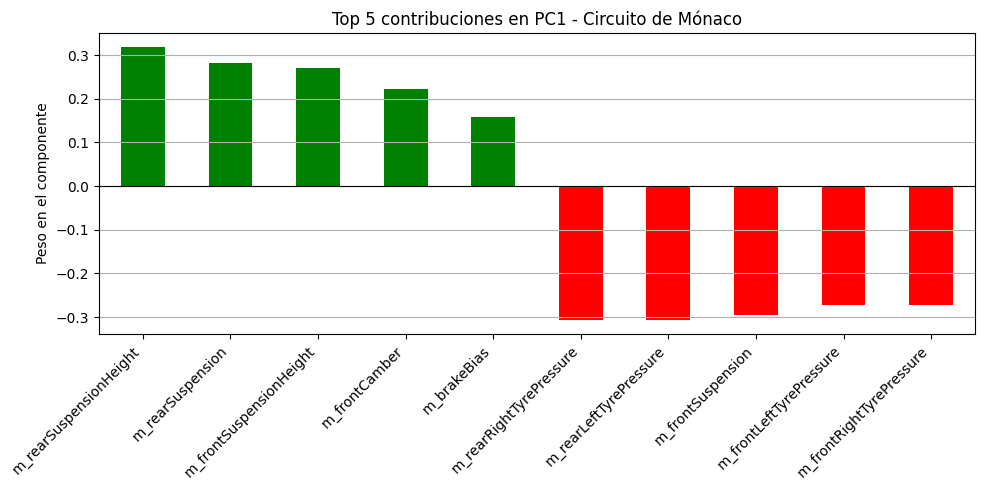


Top 5 contribuciones positivas en PC2:
m_frontToe                  0.494251
m_rearToe                   0.455879
m_rearWing                  0.276239
m_engineBraking             0.268070
m_frontRightTyrePressure    0.222228
Name: PC2, dtype: float64

Top 5 contribuciones negativas en PC2:
m_rearAntiRollBar    -0.299862
m_frontAntiRollBar   -0.252014
m_onThrottle         -0.109545
m_frontSuspension    -0.103963
m_brakePressure      -0.095993
Name: PC2, dtype: float64


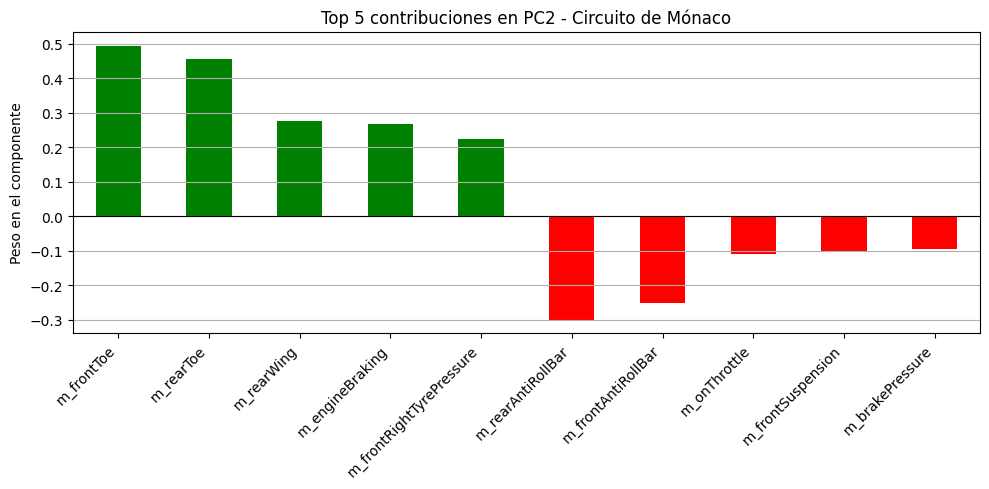


Top 5 contribuciones positivas en PC3:
m_frontAntiRollBar         0.465479
m_rearAntiRollBar          0.435939
m_rearWing                 0.320733
m_frontSuspensionHeight    0.301747
m_brakeBias                0.297728
Name: PC3, dtype: float64

Top 5 contribuciones negativas en PC3:
m_frontSuspension          -0.195894
m_frontToe                 -0.141084
m_frontWing                 0.000000
m_frontLeftTyrePressure     0.036686
m_frontRightTyrePressure    0.036686
Name: PC3, dtype: float64


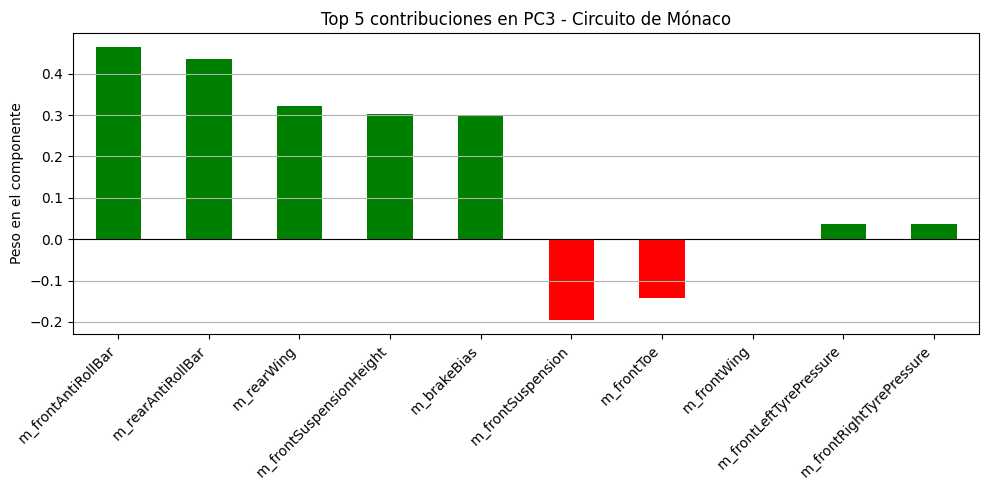


Top 5 contribuciones positivas en PC4:
m_brakePressure      0.568707
m_offThrottle        0.369256
m_rearWing           0.317611
m_rearToe            0.218754
m_frontSuspension    0.144956
Name: PC4, dtype: float64

Top 5 contribuciones negativas en PC4:
m_brakeBias                -0.343283
m_rearCamber               -0.271717
m_frontRightTyrePressure   -0.211517
m_frontLeftTyrePressure    -0.211517
m_frontCamber              -0.155562
Name: PC4, dtype: float64


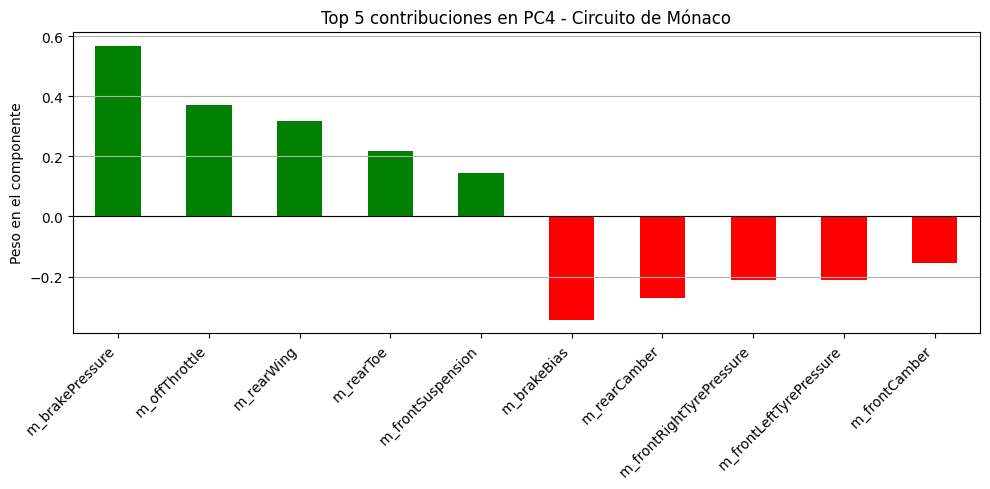

In [12]:
show_top_contributors(loadings, n=5)

Correlación entre cada uno de los componentes y el tiempo por vuelta.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def analyze_pca_vs_lap_time(X_pca, lap_times):
    """
    Analiza la relación entre cada componente principal y el tiempo por vuelta.

    Parámetros:
    - X_pca: array de shape (n_samples, n_components) obtenido de PCA.
    - lap_times: array de tiempos por vuelta (n_samples,).

    Salida:
    - Gráficos de dispersión.
    - Correlaciones de Pearson.
    - Coeficientes de determinación R² para cada componente.
    """
    n_components = X_pca.shape[1]

    for i in range(n_components):
        pc = X_pca[:, i]
        corr = np.corrcoef(pc, lap_times)[0, 1]

        # Regresión lineal simple
        reg = LinearRegression().fit(pc.reshape(-1, 1), lap_times)
        r2 = r2_score(lap_times, reg.predict(pc.reshape(-1, 1)))

        # Gráfico
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=pc, y=lap_times)
        plt.xlabel(f'PC{i+1}')
        plt.ylabel('Tiempo por vuelta')
        plt.title(f'Relación entre PC{i+1} y el tiempo por vuelta - Circuito de Mónaco\nCorrelación = {corr:.3f}, R² = {r2:.3f}')
        plt.grid(True)
        plt.show()

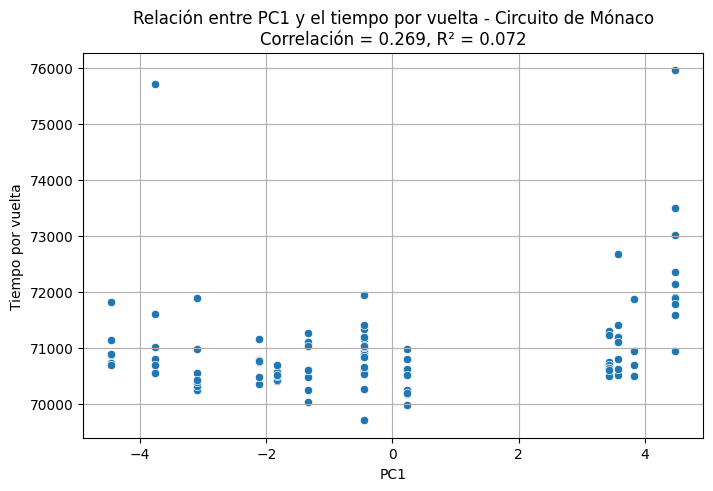

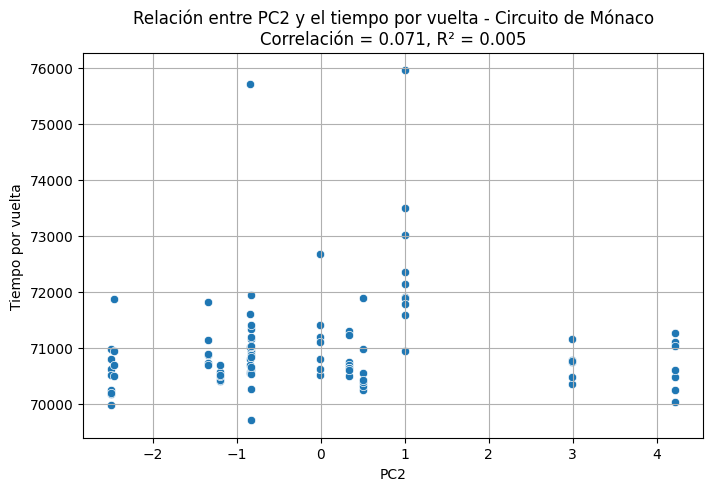

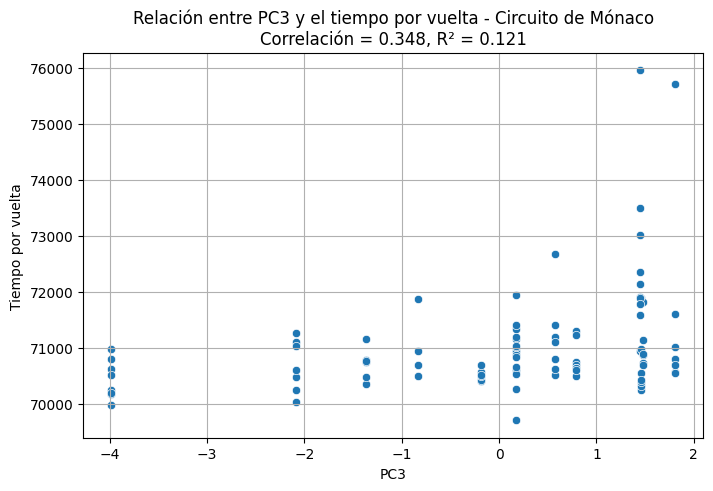

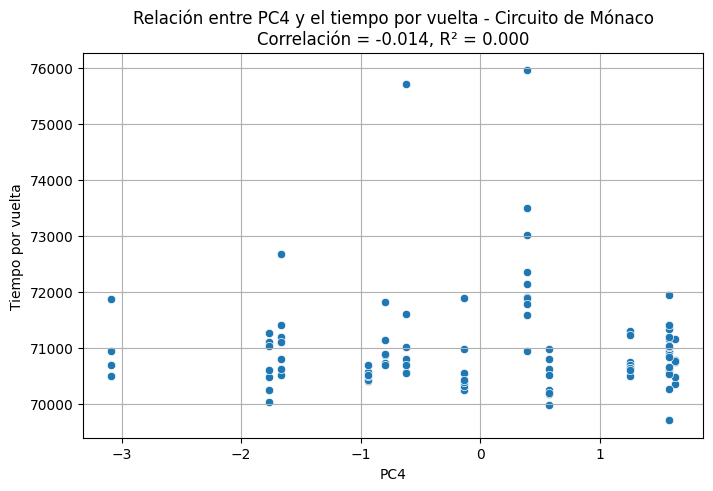

In [14]:
analyze_pca_vs_lap_time(X_pca, lap_times)

### Visualización con t-SNE

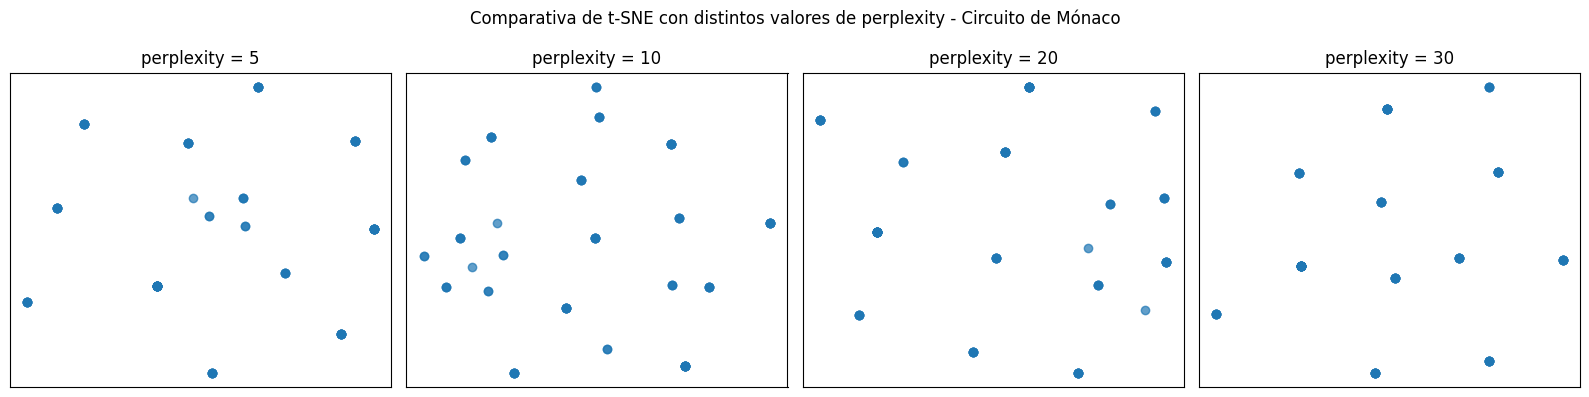

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Valores de perplexity a probar
perplexities = [5, 10, 20, 30]

fig, axs = plt.subplots(1, len(perplexities), figsize=(16, 4))
fig.suptitle("Comparativa de t-SNE con distintos valores de perplexity - Circuito de Mónaco")

for i, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, max_iter=650, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    axs[i].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
    axs[i].set_title(f"perplexity = {perp}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()

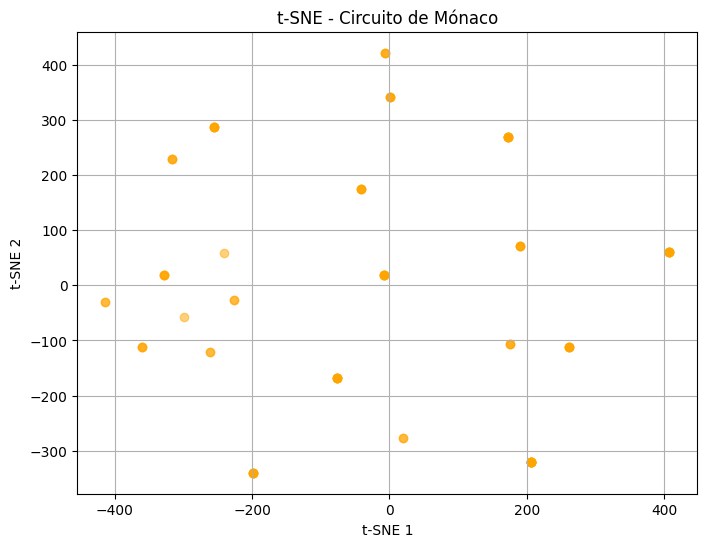

In [16]:
from sklearn.manifold import TSNE

# Aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=10, max_iter=650, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualización t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='orange', alpha=0.5)
plt.title("t-SNE - Circuito de Mónaco")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

# 🧩 Paso 3: Clustering con K-Means + Silhouette Score

En este paso buscamos identificar agrupaciones naturales (clusters) en los setups del circuito de Mónaco usando K-Means.

Pasos:
1. Calcular el Silhouette Score para valores de K entre 2 y 12 (número de reglajes distintos).
2. Elegir el mejor K.
3. Visualizar los clusters con las proyecciones obtenidas por PCA y t-SNE.

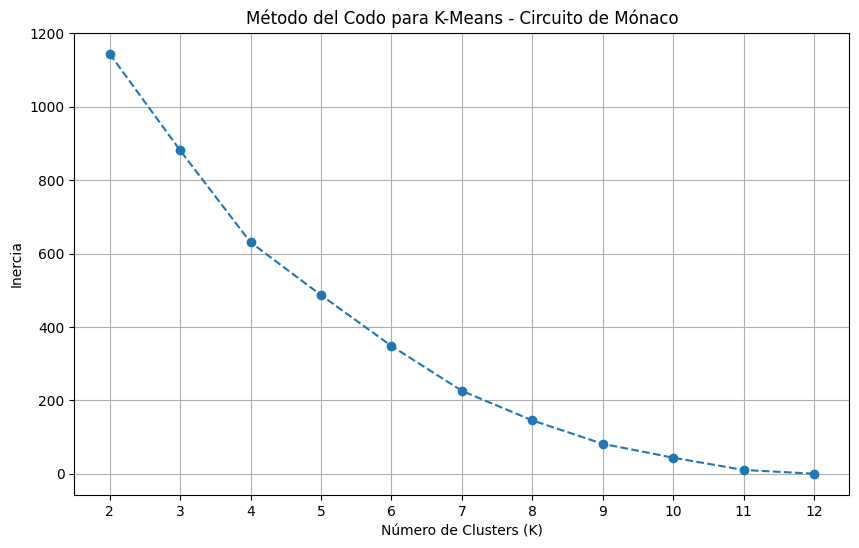

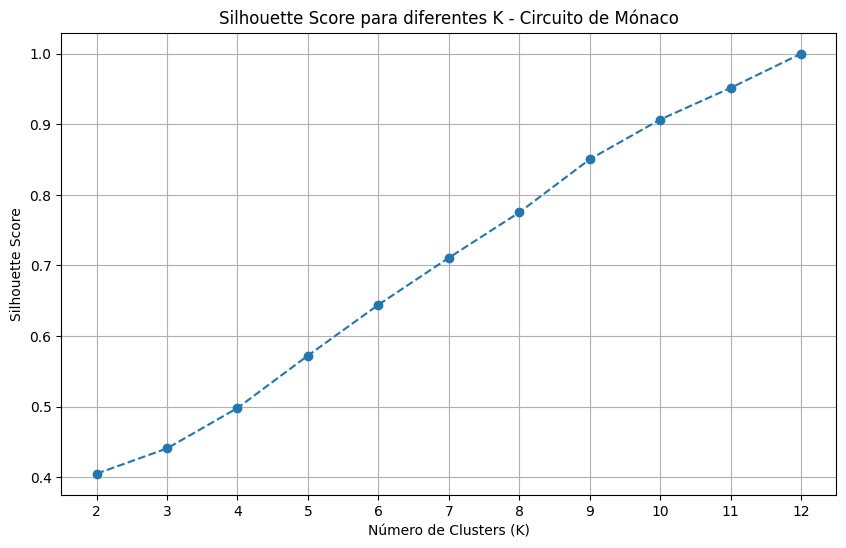

Silhouette Scores: [np.float64(0.4050177281793439), np.float64(0.44078390700057424), np.float64(0.4980129782184894), np.float64(0.5722980807867405), np.float64(0.6442950496095944), np.float64(0.7108205521693263), np.float64(0.7751444535667895), np.float64(0.8503747258417987), np.float64(0.9067092074536793), np.float64(0.951572877319427), np.float64(0.999999998198117)]
Inertia Scores: [1144.5451278486462, 881.3466955124838, 630.6331368207719, 486.82207154803734, 348.21475994135506, 225.80812040421512, 145.3200769356286, 81.38733625025485, 43.66631566983774, 10.217550260910336, 3.156004247053796e-29]


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Rango de K a probar (de 2 a 12 porque tenemos 12 reglajes como máximo)
k_range = range(2, 13)
silhouette_scores = []
inertia_scores = [] # Para el método del codo

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Añadir n_init
    kmeans.fit(X_scaled)

    # Calcular Silhouette Score
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

    # Guardar inercia para el método del codo
    inertia_scores.append(kmeans.inertia_)

# Gráfico del método del codo (Inercia)
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means - Circuito de Mónaco')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Gráfico de Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes K - Circuito de Mónaco')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Mostrar los scores para ver numéricamente
print("Silhouette Scores:", silhouette_scores)
print("Inertia Scores:", inertia_scores)

In [18]:
# Elegimos el K donde hay una granularidad moderada y que no hace un sobreajuste
# Entrenamos modelo final
best_k = 6
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
cluster_labels = kmeans_final.fit_predict(X_scaled)

### Visualización con PCA

In [19]:
# Crear DataFrame para visualización
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4"])
df_pca["cluster"] = cluster_labels
df_pca["lapTimeInMS"] = lap_times.values

# Gráfico 3D interactivo
fig = px.scatter_3d(df_pca, x="PC1", y="PC2", z="PC3",
                    color="cluster",  # Colorea por etiqueta de cluster
                    hover_data=["lapTimeInMS"],  # mostrar tiempo en hover
                    title="Clusters con K-Means (PCA 3D) - Circuito de Mónaco")

fig.update_layout(scene=dict(
    xaxis_title="Componente principal 1",
    yaxis_title="Componente principal 2",
    zaxis_title="Componente principal 3"
))

fig.show()

### Visualización con t-SNE

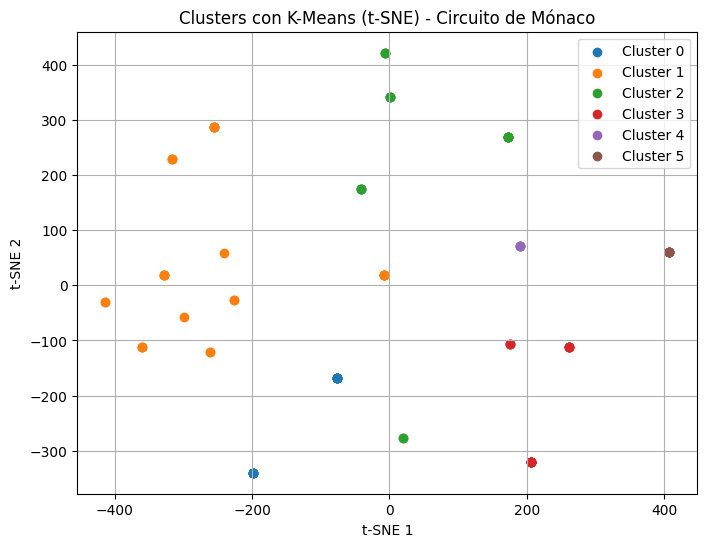

In [20]:
plt.figure(figsize=(8, 6))
for i in range(best_k):
    plt.scatter(X_tsne[cluster_labels == i, 0], X_tsne[cluster_labels == i, 1], label=f'Cluster {i}')
plt.title("Clusters con K-Means (t-SNE) - Circuito de Mónaco")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.show()

## Cálculo de centroides con K-means

In [21]:
import pandas as pd

# Reconstruir los setups escalados a su forma original
X_unscaled = pd.DataFrame(scaler.inverse_transform(X_scaled), columns=X_raw.columns)

# Añadir etiquetas de clúster y tiempo de vuelta original
X_unscaled["cluster"] = cluster_labels
X_unscaled["lapTime"] = lap_times.values

# Agrupar por clúster y calcular centroides (media de setups) y tiempo medio
centroids_df = X_unscaled.groupby("cluster").mean().reset_index()

# Ordenar por tiempo medio de vuelta (opcional, para interpretación posterior)
centroids_df = centroids_df.sort_values(by="lapTime").reset_index(drop=True)

centroids_df.head()

,cluster,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,...,m_frontSuspensionHeight,m_rearSuspensionHeight,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure,lapTime
0,0,50.0,50.00000,39.615385,41.153846,-3.5,-2.2,0.25,0.250000,37.769231,...,22.692308,55.00000,97.307692,52.692308,100.000000,26.038462,26.038462,29.269231,29.269231,70695.307692
1,1,50.0,48.62069,50.689655,35.517241,-3.5,-2.2,0.00,0.051724,39.344828,...,23.000000,57.37931,99.379310,52.172414,46.551724,23.327586,23.327586,23.648276,23.648276,70695.724138
2,4,50.0,42.00000,20.000000,30.000000,-3.5,-2.2,0.00,0.000000,27.000000,...,27.000000,81.00000,91.000000,57.000000,10.000000,20.500000,20.500000,22.500000,22.500000,71002.250000
3,2,50.0,50.00000,86.000000,25.500000,-3.5,-2.2,0.00,0.070000,39.250000,...,23.400000,49.30000,100.000000,53.400000,96.500000,26.500000,26.500000,29.500000,29.500000,71094.550000
4,5,50.0,47.00000,40.000000,45.000000,-3.2,-1.8,0.12,0.110000,29.000000,...,30.000000,70.00000,97.000000,54.000000,30.000000,21.500000,21.500000,24.000000,24.000000,71186.571429


## Exportado de centroides con K-means

In [22]:
# Exportamos los centroides para usarlos en el sistema recomendador
centroids_df.to_csv("monaco_kmeans_centroids.csv", index=False)
print("✅ Centroides exportados correctamente a 'monaco_kmeans_centroids.csv'")

✅ Centroides exportados correctamente a 'monaco_kmeans_centroids.csv'


# ⚙️ Paso 4: Clustering con DBSCAN

Utilizaremos el algoritmo DBSCAN para encontrar agrupaciones sin necesidad de definir el número de clusters.

Pasos:
1. Ajustar el modelo DBSCAN sobre los datos normalizados.
2. Visualizar los clusters con PCA y t-SNE.
3. Calcular los centroides descartando el ruido (`cluster = -1`).
4. Exportar los centroides para el sistema recomendador.

Agrupamos reglajes únicos y persistimos el tiempo más rápido.

In [23]:
# Unir X_raw y lap_times en un único DataFrame
df_full = X_raw.copy()
df_full["lapTime"] = lap_times.values

# Agrupar por combinaciones únicas de reglajes y calcular la media de tiempos
df_grouped = df_full.groupby(list(X_raw.columns)).agg({
    "lapTime": "min"
}).reset_index()

Estandarizamos reglajes únicos.

In [24]:
from sklearn.preprocessing import StandardScaler

X_unique = df_grouped.drop(columns=["lapTime"])
y_unique = df_grouped["lapTime"]

scaler = StandardScaler()
X_scaled_unique = scaler.fit_transform(X_unique)

Determinamos eps con curva k-distance.

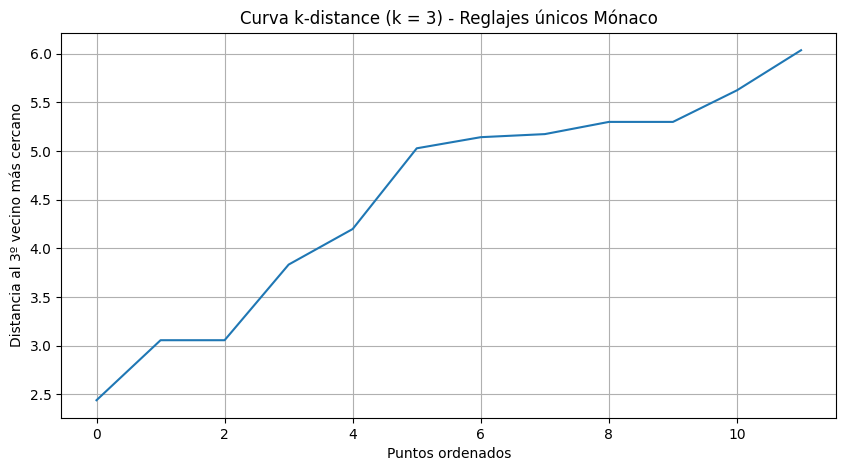

In [25]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

min_samples = 3  # ajustar de 3 a 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled_unique)
distances, indices = neighbors_fit.kneighbors(X_scaled_unique)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title(f'Curva k-distance (k = {min_samples}) - Reglajes únicos Mónaco')
plt.xlabel('Puntos ordenados')
plt.ylabel(f'Distancia al {min_samples}º vecino más cercano')
plt.grid(True)
plt.show()

Aplicamos DBSCAN sobre los datos únicos.

In [26]:
from sklearn.cluster import DBSCAN
import numpy as np

from sklearn.cluster import DBSCAN

# Estimar eps visualmente desde la curva anterior
eps = 5.0  # lo ajustamos en función de la gráfica
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
db_labels = dbscan.fit_predict(X_scaled_unique)

# Añadir los resultados al DataFrame agrupado
df_grouped["cluster"] = db_labels

# Contar etiquetas encontradas
n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)
print(f"🔍 DBSCAN encontró {n_clusters_db} clusters y {n_noise} puntos de ruido.")

🔍 DBSCAN encontró 1 clusters y 6 puntos de ruido.


### Visualización con PCA

In [27]:
from sklearn.decomposition import PCA
import plotly.express as px

X_pca_dbscan = pca.fit_transform(X_scaled_unique)

df_grouped[["PC1", "PC2", "PC3", "PC4"]] = X_pca_dbscan

fig = px.scatter_3d(df_grouped, x="PC1", y="PC2", z="PC3",
                    color="cluster",
                    hover_data=["lapTime"],
                    title="Clusters DBSCAN (PCA 3D) - Circuito de Mónaco")
fig.show()

### Visualización con t-SNE

In [28]:
tsne = TSNE(n_components=2, perplexity=2, max_iter=1000, random_state=42)
X_tsne_dbscan = tsne.fit_transform(X_scaled_unique)

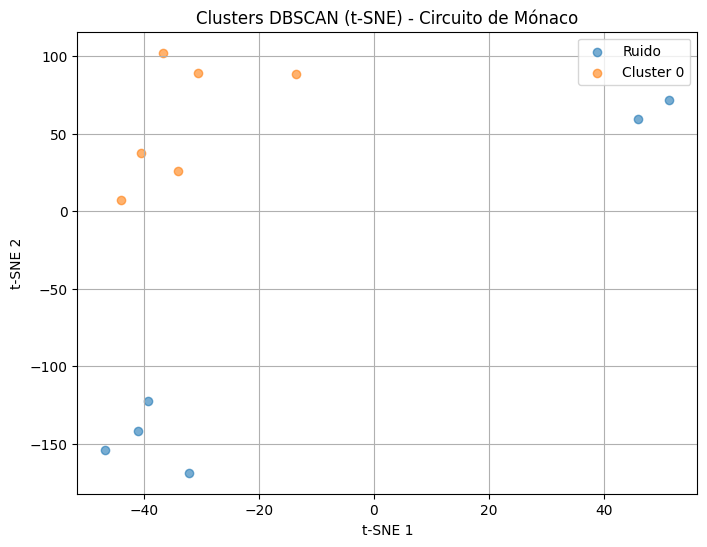

In [29]:
plt.figure(figsize=(8, 6))
unique_labels = np.unique(db_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    class_member_mask = (db_labels == k)
    label = "Ruido" if k == -1 else f"Cluster {k}"
    plt.scatter(X_tsne_dbscan[class_member_mask, 0], X_tsne_dbscan[class_member_mask, 1],
                label=label, alpha=0.6)

plt.title("Clusters DBSCAN (t-SNE) - Circuito de Mónaco")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.show()

## Cálculo de centroides (sin ruido)

In [30]:
# Reconstrucción de los reglajes originales desde los datos únicos
X_db_unscaled = pd.DataFrame(scaler.inverse_transform(X_scaled_unique),
                             columns=X_raw.columns)  # usar las columnas originales de reglajes

# Añadir etiquetas de cluster y tiempos mínimos
X_db_unscaled["cluster"] = db_labels  # obtenidos de DBSCAN
X_db_unscaled["lapTime"] = y_unique.values  # mejores tiempos por reglaje

# Filtrar los puntos que no son ruido
X_db_filtered = X_db_unscaled[X_db_unscaled["cluster"] != -1]

# Calcular centroides de cada cluster y tiempo medio por vuelta
db_centroids_df = X_db_filtered.groupby("cluster").mean().reset_index()

# Ordenar por tiempo medio (el más bajo primero)
db_centroids_df = db_centroids_df.sort_values(by="lapTime").reset_index(drop=True)

# Mostrar primeros centroides
db_centroids_df.head()

,cluster,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,...,m_frontSuspensionHeight,m_rearSuspensionHeight,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure,lapTime
0,0,50.0,49.166667,70.833333,27.5,-3.5,-2.2,0.0,0.05,39.333333,...,22.833333,53.333333,99.5,52.666667,73.333333,24.75,24.75,26.716667,26.716667,70262.333333


## Exportado de centroides con DBSCAN

In [31]:
# Exportar a CSV para uso en recomendador
db_centroids_df.to_csv("monaco_dbscan_centroids.csv", index=False)
print("Centroides DBSCAN exportados correctamente a 'monaco_dbscan_centroids.csv'")

Centroides DBSCAN exportados correctamente a 'monaco_dbscan_centroids.csv'


# 🧐 Paso 5: Intrepretación de Clusters
Después de visualizar los distintos cluster usando algoritmos de clustering (K-means y DBSCAN), vamos a identificar cuál es el cluster donde el tiempo por vuelta es más rápido. Para ello, tomaremos los tiempos por vuelta de cada cluster y haremos la media de ellos, viendo así cuál es el tiempo por vuelta medio más bajo (la recomendación).

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_cluster_performance(cluster_labels, lap_times, X_original, feature_names=None):
    """
    Evalúa el rendimiento por cluster con tiempos de vuelta y devuelve el reglaje medio del mejor cluster.

    Parámetros:
    - cluster_labels: array (n_samples,) con etiquetas de clustering (KMeans, DBSCAN, etc.).
    - lap_times: array (n_samples,) con los tiempos por vuelta.
    - X_original: array o DataFrame con los reglajes sin escalar (shape: n_samples, n_features).
    - feature_names: lista opcional con nombres de las columnas de X_original.

    Retorna:
    - best_cluster: etiqueta del cluster con mejor tiempo medio.
    - average_setup: Series con el reglaje promedio de ese cluster.
    """

    # Crear DataFrame con resultados
    df = pd.DataFrame({
        'cluster': cluster_labels,
        'lap_time': lap_times
    })

    # Agrupación por cluster
    summary = df.groupby('cluster')['lap_time'].agg(['mean', 'std', 'count']).sort_values('mean')

    print("📊 Resumen por cluster (ordenado por mejor tiempo medio):")
    display(summary)

    # Visualización
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='cluster', y='lap_time', data=df)
    plt.title("Distribución del tiempo por vuelta por cluster - Circuito de Mónaco")
    plt.xlabel("Cluster")
    plt.ylabel("Tiempo por vuelta")
    plt.grid(True)
    plt.show()

    # Identificar el mejor cluster
    best_cluster = summary.index[0]
    print(f"🏁 El cluster más rápido en Mónaco es el #{best_cluster} con tiempo medio de {summary.loc[best_cluster, 'mean']:.3f} s")

    # Cálculo del reglaje promedio de ese cluster
    if isinstance(X_original, pd.DataFrame):
        best_setups = X_original[cluster_labels == best_cluster]
    else:
        best_setups = pd.DataFrame(X_original[cluster_labels == best_cluster],
                                   columns=feature_names)

    average_setup = best_setups.mean()

    print("\n🔧 Reglaje promedio del mejor cluster:")
    display(average_setup)

    return best_cluster, average_setup

## K-Means

📊 Resumen por cluster (ordenado por mejor tiempo medio):


,mean,std,count
cluster,,,
0,70695.307692,372.929034,13
1,70695.724138,465.747011,29
4,71002.250000,606.395567,4
2,71094.550000,1182.072376,20
5,71186.571429,727.425565,7
3,71745.777778,1361.512073,18


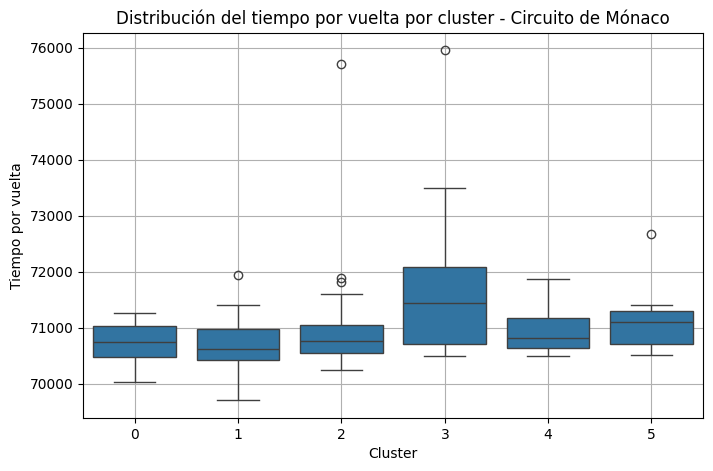

🏁 El cluster más rápido en Mónaco es el #0 con tiempo medio de 70695.308 s

🔧 Reglaje promedio del mejor cluster:


,0
m_frontWing,50.000000
m_rearWing,50.000000
m_onThrottle,39.615385
m_offThrottle,41.153846
m_frontCamber,-3.500000
m_rearCamber,-2.200000
m_frontToe,0.250000
m_rearToe,0.250000
m_frontSuspension,37.769231
m_rearSuspension,5.692308


In [33]:
best_cluster, best_setup = analyze_cluster_performance(
    cluster_labels=cluster_labels,
    lap_times=lap_times,
    X_original=X_raw,  # sin escalar
    feature_names=X_raw.columns.tolist()
)

## DBSCAN

📊 Resumen por cluster (ordenado por mejor tiempo medio):


,mean,std,count
cluster,,,
0,70262.333333,367.155916,6
-1,70477.666667,291.670133,6


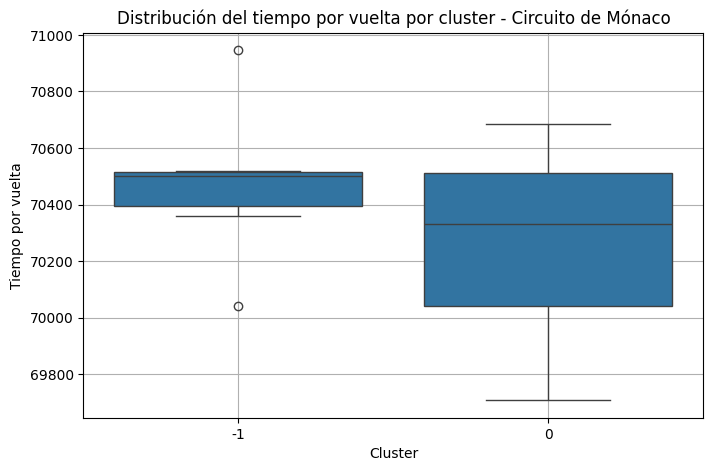

🏁 El cluster más rápido en Mónaco es el #0 con tiempo medio de 70262.333 s

🔧 Reglaje promedio del mejor cluster:


,0
m_frontWing,50.000000
m_rearWing,49.166667
m_onThrottle,70.833333
m_offThrottle,27.500000
m_frontCamber,-3.500000
m_rearCamber,-2.200000
m_frontToe,0.000000
m_rearToe,0.050000
m_frontSuspension,39.333333
m_rearSuspension,6.000000


In [34]:
best_cluster, best_setup = analyze_cluster_performance(
    cluster_labels=db_labels,
    lap_times=y_unique,
    X_original=X_unique,
    feature_names=X_unique.columns.tolist()
)

## Clusters Lentos Vs Rápidos
Finalmente, miraremos aquellos clusters cuyos centroides tienen un tiempo por vuelta superior o inferior a la media de todos los tiempos.

In [35]:
from scipy.stats import mode
import matplotlib.pyplot as plt
import numpy as np

def plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="mean"):
    """
    Dibuja un gráfico de barras para comparar tiempos medios de clusters contra la media o moda global.

    Parámetros:
    - centroids_df: DataFrame con columna 'cluster' y 'lapTime'
    - lap_times: Serie o array con todos los tiempos por vuelta
    - title_suffix: "K-Means" o "DBSCAN"
    - reference: 'mean' o 'mode' (define con qué se comparan los centroides)
    """
    # Selección de umbral de comparación
    if reference == "mean":
      ref_value = lap_times.mean()
      ref_label = f"Media global: {ref_value:.0f} ms"
    elif reference == "median":
      ref_value = np.median(lap_times)
      ref_label = f"Mediana global: {ref_value:.0f} ms"
    elif reference == "mode":
      ref_result = mode(lap_times, keepdims=True)  # <-- importante porque sino se devuelve un escalar en vez de un array
      ref_value = ref_result.mode[0]
      ref_label = f"Moda global: {ref_value:.0f} ms"
    else:
        raise ValueError("Parámetro 'reference' debe ser 'mean' o 'mode'.")

    # Gráfico
    plt.figure(figsize=(8, 6))
    plt.bar(centroids_df["cluster"], centroids_df["lapTime"], color='skyblue', edgecolor='black')

    # Línea horizontal de referencia
    plt.axhline(ref_value, color='red', linestyle='--', label=ref_label)

    # Anotaciones: "Rápido"/"Lento" con respecto al umbral
    for idx, row in centroids_df.iterrows():
        label = "Rápido" if row["lapTime"] < ref_value else "Lento"
        plt.text(row["cluster"], row["lapTime"] + 100, label, ha='center', fontsize=9)

    # Ajuste eje Y
    min_lap = centroids_df["lapTime"].min()
    max_lap = centroids_df["lapTime"].max()
    delta = max_lap - min_lap
    margin = delta * 0.25
    plt.ylim(min_lap - margin, max_lap + margin)

    # Título y estilo
    plt.title(f"Comparación de Clusters: Rápidos vs Lentos ({title_suffix}, ref: {reference}) - Circuito de Mónaco")
    plt.xlabel("Cluster")
    plt.ylabel("Tiempo medio por vuelta (ms)")
    plt.legend()
    plt.grid(True)
    plt.show()

## K-means

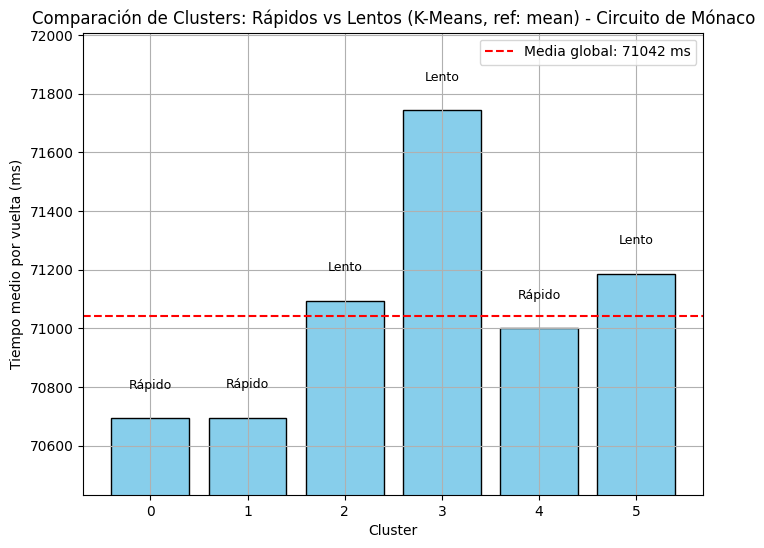

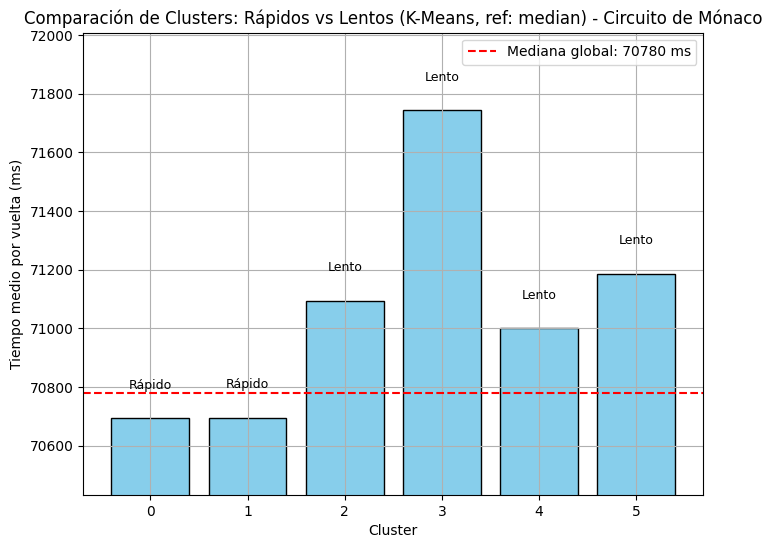

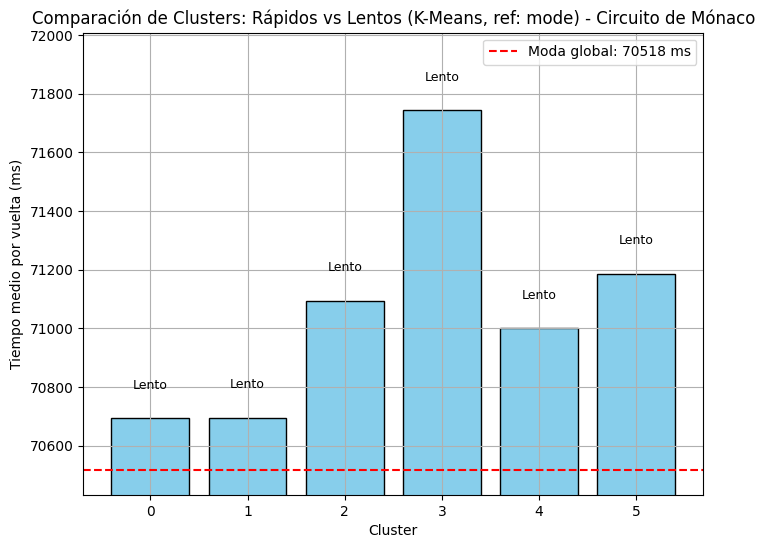

In [36]:
plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="mean")
plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="median")
plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="mode")

## DBSCAN

<ipython-input-35-1743178982>:46: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



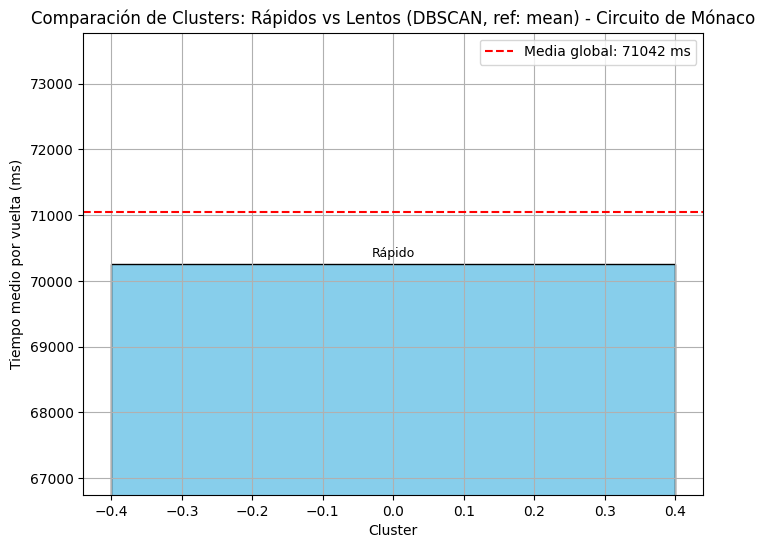

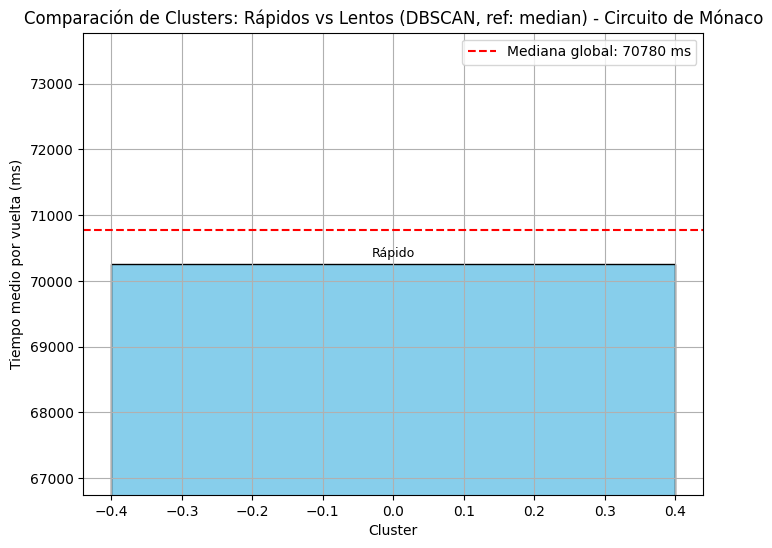

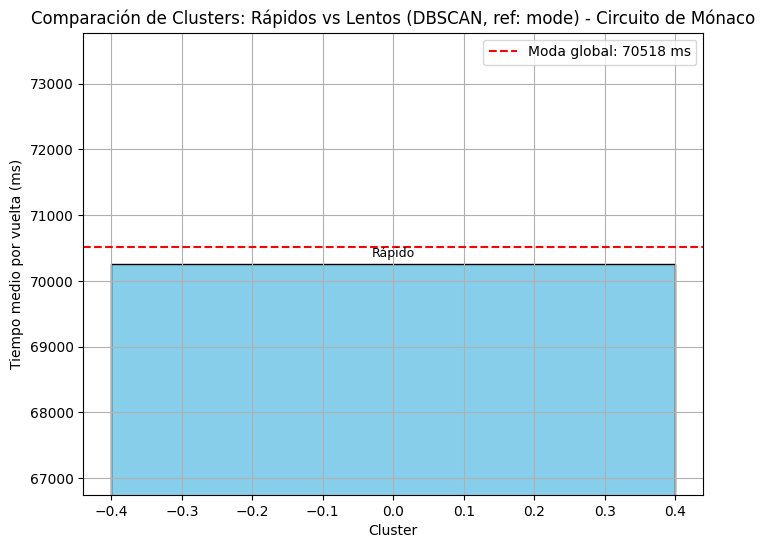

In [37]:
plot_fast_vs_slow_clusters(db_centroids_df, lap_times, title_suffix="DBSCAN", reference="mean")
plot_fast_vs_slow_clusters(db_centroids_df, lap_times, title_suffix="DBSCAN", reference="median")
plot_fast_vs_slow_clusters(db_centroids_df, lap_times, title_suffix="DBSCAN", reference="mode")